<a href="https://colab.research.google.com/github/ppunkz/Portfoliobuilding/blob/master/Portfolio_Risk_Management_Using_Monte_Carlo_Simulations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Importing all required libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_datareader as web
from matplotlib.ticker import FuncFormatter
#Installing the Portfolio Optimzation Library
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from matplotlib.ticker import FuncFormatter

In [ ]:
tickers = ['GOOGL','FB','AAPL','NFLX','AMZN']
thelen = len(tickers)
price_data = []
for ticker in range(thelen):
   prices = web.DataReader(tickers[ticker], start='2018-06-20', end = '2020-06-20', data_source='yahoo')
   price_data.append(prices[['Adj Close']])
df_stocks = pd.concat(price_data, axis=1)
df_stocks.columns=tickers
df_stocks.tail()

,GOOGL,FB,AAPL,NFLX,AMZN
Date,,,,,
2020-06-15,1420.739990,232.500000,342.372681,425.500000,2572.679932
2020-06-16,1446.469971,235.649994,351.446320,436.130005,2615.270020
2020-06-17,1452.540039,235.529999,350.957214,447.769989,2640.979980
2020-06-18,1434.119995,235.940002,351.096985,449.869995,2653.979980
2020-06-19,1424.640015,238.789993,349.090576,453.720001,2675.010010


In [ ]:
#Annualized Return
mu = expected_returns.mean_historical_return(df_stocks)
#Sample Variance of Portfolio
Sigma = risk_models.sample_cov(df_stocks)
#Max Sharpe Ratio - Tangent to the EF
from pypfopt import objective_functions, base_optimizer
ef = EfficientFrontier(mu, Sigma, weight_bounds=(0,1)) #weight bounds in negative allows shorting of stocks
sharpe_pfolio=ef.max_sharpe() 
#May use add objective to ensure minimum zero weighting to individual stocks
sharpe_pwt=ef.clean_weights()
print(sharpe_pwt)

OrderedDict([('GOOGL', 0.0), ('FB', 0.0), ('AAPL', 0.92163), ('NFLX', 0.0), ('AMZN', 0.07837)])


In [ ]:
#VaR Calculation
ticker_rx2 = []
#Convert Dictionary to list of asset weights from Max Sharpe Ratio Portfolio
sh_wt = list(sharpe_pwt.values())
sh_wt=np.array(sh_wt)

In [ ]:
#Cumulative return (holding period returns)
df_stocks_rx = df_stocks.pct_change()
ticker_final = (df_stocks_rx+1).cumprod()
print(ticker_final)

               GOOGL        FB      AAPL      NFLX      AMZN
Date                                                        
2018-06-20       NaN       NaN       NaN       NaN       NaN
2018-06-21  0.987644  0.997525  0.994424  0.996833  0.988652
2018-06-22  0.987518  0.998713  0.991528  0.986395  0.980338
2018-06-25  0.962173  0.972030  0.976783  0.922545  0.950328
2018-06-26  0.956548  0.985149  0.988901  0.958321  0.966293
...              ...       ...       ...       ...       ...
2020-06-15  1.199878  1.150990  1.889366  1.020971  1.470036
2020-06-16  1.221609  1.166584  1.939438  1.046478  1.494372
2020-06-17  1.226735  1.165990  1.936739  1.074407  1.509062
2020-06-18  1.211178  1.168020  1.937510  1.079446  1.516491
2020-06-19  1.203172  1.182129  1.926438  1.088684  1.528507

[504 rows x 5 columns]


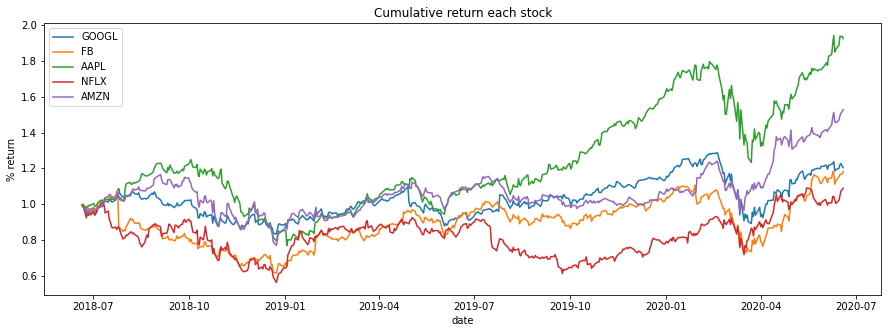

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(ticker_final)
plt.legend(ticker_final)
plt.title('Cumulative return each stock')
plt.ylabel('% return')
plt.xlabel('date')
plt.show()

In [ ]:
#Taking Latest Values of Return
pret = []
pre1 = []
price =[]
for x in range(thelen):
  pret.append(ticker_final.iloc[[-1],[x]])
  price.append((df_stocks.iloc[[-1],[x]]))
pre1 = pd.concat(pret,axis=1)
pre1 = np.array(pre1)
price = pd.concat(price,axis=1)
varsigma = pre1.std()
#expected return portfolio = sum(w_i*er_i)
ex_rtn=pre1.dot(sh_wt)
print('The weighted expected portfolio return for selected time period is ' + str(ex_rtn))
#ex_rtn = (ex_rtn)**0.5-(1) #Annualizing the cumulative return (will not affect outcome)
weighted_value=price.dot(sh_wt) #Calculating weighted value
print('The weighted value is ' + str(weighted_value[0]))

The weighted expected portfolio return for selected time period is [1.89525216]
The weighted value is 531.3728821826172


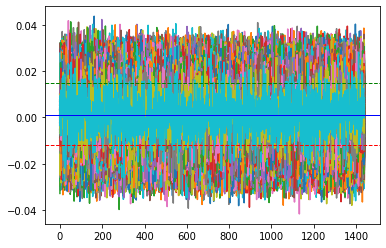

In [ ]:
from scipy.stats import norm
import math
Time=1440 #No of days(steps or trading days in this case)
lt_price=[]
final_res=[]
for i in range(10000): #10000 runs of simulation
  daily_returns=(np.random.normal(ex_rtn/Time,varsigma/math.sqrt(Time),Time))
  plt.plot(daily_returns)
plt.axhline(np.percentile(daily_returns,5), color='r', linestyle='dashed', linewidth=1)
plt.axhline(np.percentile(daily_returns,95), color='g', linestyle='dashed', linewidth=1)
plt.axhline(np.mean(daily_returns), color='b', linestyle='solid', linewidth=1)
plt.show()
## Range of returns in day of 1440 minutes, Red dash = Min loss, Green dash = Min gain ##

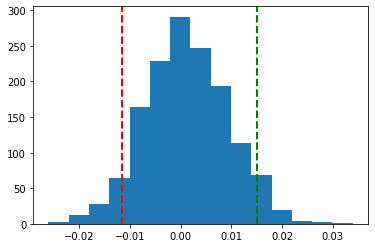

In [ ]:
plt.hist(daily_returns,bins=15)
plt.axvline(np.percentile(daily_returns,5), color='r', linestyle='dashed', linewidth=2)
plt.axvline(np.percentile(daily_returns,95), color='g', linestyle='dashed', linewidth=2)
plt.show()

In [ ]:
print(np.percentile(daily_returns,5),np.percentile(daily_returns,95)) 
#VaR - Minimum loss of 5.7% at a 5% probability, also a gain can be higher than 15% with a 5 % probability
pvalue = 1000 #portfolio value
print('$Amount required to cover minimum losses for one day is ' + str(pvalue* - np.percentile(daily_returns,5)))

-0.011663768444249208 0.01502492723503161
$Amount required to cover minimum losses for one day is 11.663768444249209


In [ ]:
 #https://towardsdatascience.com/var-calculation-using-monte-carlo-simulations-40b2bb417a67